<a href="https://colab.research.google.com/github/DiMorten/FCN_ConvLSTM_Crop_Recognition_Open_Set/blob/coords3/train_and_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies

In [1]:
!pip install icecream
%tensorflow_version 1.x
import os
!pip install kora
from kora import drive
import time
!pip install colorama

ds_path='/content/drive/My Drive/PhD/datasets/cv_data/'

TensorFlow 1.x selected.


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
git_clone = True

if git_clone == True:
  os.chdir('/content')
  %rm -rf FCN_ConvLSTM_Crop_Recognition_Open_Set
  !git clone --branch coords3 https://github.com/DiMorten/FCN_ConvLSTM_Crop_Recognition_Open_Set.git

Cloning into 'FCN_ConvLSTM_Crop_Recognition_Open_Set'...
remote: Enumerating objects: 1747, done.
remote: Counting objects: 100% (1747/1747), done.
remote: Compressing objects: 100% (1243/1243), done.
remote: Total 1747 (delta 1121), reused 935 (delta 333), pack-reused 0
Receiving objects: 100% (1747/1747), 37.28 MiB | 28.53 MiB/s, done.
Resolving deltas: 100% (1121/1121), done.


## Download images into proper folder

In [4]:
!cp -r /content/drive/MyDrive/PhD/datasets/cv_data /content/FCN_ConvLSTM_Crop_Recognition_Open_Set/dataset/dataset/

In [5]:
os.chdir('/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src')
os.getcwd()
os.listdir()

['obj',
 'deb.py',
 'metrics.py',
 'model.py',
 'keras_weighted_categorical_crossentropy.py',
 'dataset.py',
 'model_best_UUnet4ConvLSTM_jun_cv_criteria_0_92',
 'model_input_mode.py',
 'generator.py',
 'densnet.py',
 'parameters',
 'monitor.py',
 'densnet_timedistributed.py',
 'patch_extractor.py',
 'analysis',
 '__init__.py',
 'main.py']

In [6]:
from colorama import init
init()
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Conv2DTranspose
# from keras.callbacks import ModelCheckpoint , EarlyStopping
from keras.optimizers import Adam,Adagrad 
from keras.models import Model
from keras import backend as K
import keras

import numpy as np
from sklearn.utils import shuffle
import cv2
import argparse
import tensorflow as tf

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import metrics
import sys
import glob

from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,classification_report
# Local
from densnet import DenseNetFCN
from densnet_timedistributed import DenseNetFCNTimeDistributed

#from metrics import fmeasure,categorical_accuracy
import deb
from keras_weighted_categorical_crossentropy import weighted_categorical_crossentropy, sparse_accuracy_ignoring_last_label, weighted_categorical_crossentropy_ignoring_last_label, categorical_focal_ignoring_last_label, weighted_categorical_focal_ignoring_last_label
from keras.models import load_model
from keras.layers import ConvLSTM2D, UpSampling2D, multiply
from keras.utils.vis_utils import plot_model
from keras.regularizers import l1,l2
import time
import pickle
#from keras_self_attention import SeqSelfAttention
import pdb
import pathlib
from pathlib import Path, PureWindowsPath
from keras.layers import Conv3DTranspose, Conv3D

from keras.callbacks import EarlyStopping
import tensorflow as tf
from collections import Counter


#from datagenerator import DataGenerator
from generator import DataGenerator, DataGeneratorWithCoords, DataGeneratorWithCoordsPatches

import matplotlib.pyplot as plt
sys.path.append('../../../dataset/dataset/patches_extract_script/')
from dataSource import DataSource, SARSource, OpticalSource, Dataset, LEM, LEM2, CampoVerde, OpticalSourceWithClouds, Humidity
from model_input_mode import MIMFixed, MIMVarLabel, MIMVarSeqLabel, MIMVarLabel_PaddedSeq, MIMFixedLabelAllLabels, MIMFixed_PaddedSeq
from parameters.parameters_reader import ParamsTrain

from icecream import ic
from monitor import Monitor, MonitorNPY, MonitorGenerator, MonitorNPYAndGenerator
import natsort
from model import NetModel, ModelFit, ModelLoadGenerator, ModelLoadGeneratorDebug, ModelLoadGeneratorWithCoords, ModelLoadEachBatch
from dataset import Dataset, DatasetWithCoords

from patch_extractor import PatchExtractor
ic.configureOutput(includeContext=False)
np.random.seed(2021)
tf.set_random_seed(2021)

from main import TrainTest

Using TensorFlow backend.


['parameters_openset_specifyunknownclasses.json', 'parameters_openset_lessclass8.json', 'no_mode.json', 'twokkc_parameters_closedset_groupclasses.json', 'twokkc_parameters_openset.json', 'allkkc_parameters_openset.json', 'cv', 'parameters_closedset_groupclasses_lessclass8.json', 'save_nonaugmented_train_patches_lessclass8.json', 'parameters_reader.py', 'parameters_openset.json', '__pycache__', 'parameters_closedset_groupclasses.json', 'twokkc_save_nonaugmented_train_patches.json', 'save_nonaugmented_train_patches_unknownclasses.json', 'allkkc_save_nonaugmented_train_patches.json', 'save_nonaugmented_train_patches.json', '__init__.py']


ic| self.seq_date: 'jun'


self.known_classes [1, 2, 6, 8]
[@debug] paramsTrain.seq_mode = fixed
[@debug] paramsTrain.mim = <model_input_mode.MIMFixed_PaddedSeq object at 0x7f80c6e93b50>


In [7]:
!nvidia-smi

Tue Jul 20 19:41:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set parameters

Parameters can be modified in /content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src/parameters/parameters_reader.py

In [8]:


paramsTrain = ParamsTrain('parameters/')
paramsTrain.mim = MIMFixed_PaddedSeq()

paramsTrain.dataSource = SARSource()

trainTest = TrainTest(paramsTrain)

patchExtractor = PatchExtractor(paramsTrain, trainTest.ds)	


['parameters_openset_specifyunknownclasses.json', 'parameters_openset_lessclass8.json', 'no_mode.json', 'twokkc_parameters_closedset_groupclasses.json', 'twokkc_parameters_openset.json', 'allkkc_parameters_openset.json', 'cv', 'parameters_closedset_groupclasses_lessclass8.json', 'save_nonaugmented_train_patches_lessclass8.json', 'parameters_reader.py', 'parameters_openset.json', '__pycache__', 'parameters_closedset_groupclasses.json', 'twokkc_save_nonaugmented_train_patches.json', 'save_nonaugmented_train_patches_unknownclasses.json', 'allkkc_save_nonaugmented_train_patches.json', 'save_nonaugmented_train_patches.json', '__init__.py']


ic| self.seq_date: 'jun'


self.known_classes [1, 2, 6, 8]
[@debug] self.ds = <dataSource.CampoVerde object at 0x7f80c10a6a90>
20151029
20151110
20151122
20151204
20151216
20160121
20160214
20160309
20160321
20160508
20160520
20160613
dotys_sin_cos.shape (12, 2)
[302, 314, 326, 338, 350, 21, 45, 69, 81, 129, 141, 165]
[[0.05084 0.7197 ]
 [0.1053  0.807  ]
 [0.1764  0.8813 ]
 [0.2612  0.9395 ]
 [0.3562  0.979  ]
 [0.6685  0.9707 ]
 [0.843   0.8643 ]
 [0.96    0.6963 ]
 [0.99    0.598  ]
 [0.905   0.2068 ]
 [0.8364  0.1301 ]
 [0.66    0.02637]]


ic| self.dataSource: <dataSource.SARSource object at 0x7f80c10a6a50>
ic| self.conf['path']/self.label_folder/"/": PosixPath('/')
ic| self.conf["in_npy_path"]: PosixPath('../../../dataset/dataset/cv_data/in_sar')
ic| self.conf["train"]["mask"]["dir"]: PosixPath('../../../dataset/dataset/cv_data/TrainTestMask.tif')
ic| os.getcwd(): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'


## Download or load sequence of images


In [9]:
if paramsTrain.getFullIms == True:
  patchExtractor.getFullIms()	
else:
  patchExtractor.fullImsLoad()


ic| patch["full_ims"].shape: (12, 8492, 7995, 2)
ic| self.dataset.im_list: ['20151029_S1',
                           '20151110_S1',
                           '20151122_S1',
                           '20151204_S1',
                           '20151216_S1',
                           '20160121_S1',
                           '20160214_S1',
                           '20160309_S1',
                           '20160321_S1',
                           '20160508_S1',
                           '20160520_S1',
                           '20160613_S1']


0 0
[@debug] conf["in_npy_path"]/(im_names[t_step]+".npy") = ../../../dataset/dataset/cv_data/in_sar/20151029_S1.npy
[@debug] patch["full_ims"].dtype = float16
[@debug] np.average(patch["full_ims"][t_step]) = 0.1871337890625
[@debug] np.max(patch["full_ims"][t_step]) = 1.0
[@debug] np.min(patch["full_ims"][t_step]) = 4.172325134277344e-07
../../../dataset/dataset/cv_data/labels/20151029_S1.tif
[@debug] conf["path"]/(self.dataSource.label_folder+"/"+label_names[t_step]+".tif") = ../../../dataset/dataset/cv_data/labels/20151029_S1.tif
[@debug] np.unique(patch["full_label_ims"][t_step],return_counts=True) = (array([ 0,  1,  2,  6,  7,  8,  9, 10, 11], dtype=int8), array([61778564,    45178,    51808,   131138,   438371,   155189,
        5136068,     1007,   156217]))
1 0
[@debug] conf["in_npy_path"]/(im_names[t_step]+".npy") = ../../../dataset/dataset/cv_data/in_sar/20151110_S1.npy
[@debug] patch["full_ims"].dtype = float16
[@debug] np.average(patch["full_ims"][t_step]) = 0.180419921875


ic| patch["full_ims"].shape: (12, 8492, 7995, 2)
ic| patch["full_label_ims"].shape: (12, 8492, 7995)
ic| patch["full_ims"].dtype: dtype('float16')
ic| patch["full_label_ims"].dtype: dtype('int8')


[@debug] np.unique(patch['full_label_ims'],return_counts=True) = (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int8), array([741342768,  17247080,   7809932,  12457060,    185790,     51702,
         2462898,   5372125,   1862268,  24044169,     12084,   1874604]))
0.0 1.0 0.1702
[@debug] self.dataset.name = cv
[@debug] self.dataset.scaler_name = cv
[@debug] self.dataset.seq_mode = fixed
[@debug] self.dataset.seq_date = jun
[@debug] self.dataset.scaler_load = False
[@debug] im.shape = (12, 8492, 7995, 2)
[@debug] im_flat[mask_flat==1,:].shape = (38664648, 2)
0.0001407 1.0 0.0779
[@debug] im_norm.shape = (12, 8492, 7995, 2)
FINISHED NORMALIZING, RESULT:
-1.432 51.53 3.117
[@debug] im.shape = (12, 8492, 7995)
[@debug] mask_train.shape = (8492, 7995)
[@debug] im.dtype = uint8
[@debug] mask_train.dtype = uint8
[@debug] im_train.shape = (12, 8492, 7995)
Train masked unique/count [ 0  1  2  3  4  5  6  7  8  9 10 11] [776057832   9399025   4170646   6930141    103494     346

ic| self.paramsTrain.path / 'full_ims/full_ims_test.npy': PosixPath('../../../dataset/dataset/cv_data/full_ims/full_ims_test.npy')


## Extract coords of image patches

In [10]:

if paramsTrain.coordsExtract == True:
  patchExtractor.extract()

del patchExtractor


STARTED PATCH EXTRACTION
[@debug] gridx.shape = (250,)
[@debug] gridy.shape = (266,)


ic| coords_train.shape: (4983, 2), coords_test.shape: (4626, 2)
ic| coords_train.dtype: dtype('int64')
ic| coords_train[0]: array([7568,  656])


## Train and evaluate


ic| self.model_name: 'model_best_UUnet4ConvLSTM_jun_cv_nomode.h5'


Initializing object...
12 2
[@debug] self.channel_n = 2
[@debug] self.t_len = 12
Initializing Dataset instance


ic| os.path.dirname(os.path.abspath(__file__)): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'
ic| os.getcwd(): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'
ic| self.patches['train']['coords'].shape: (4983, 2)
ic| np.unique(self.full_label_train, return_counts=True): (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8),
                                                           array([64671486,   710232,  1374508,    31550,   136800,   212701,
                                                                    71804,   617076,      699,    66684]))
ic| np.unique(self.full_label_test, return_counts=True): (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8),
                                                          array([65000618,   730790,  1199149,    25986,    88785,   312353,
                                                                   83385,   362633,      308,    89533]))
ic|

[@debug] np.unique(self.full_label_train, return_counts=True) = (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8), array([64671486,   710232,  1374508,    31550,   136800,   212701,
          71804,   617076,      699,    66684]))


ic| self.labels2new_labels: {0: 0, 2: 1, 3: 2, 4: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8, 11: 9}
    self.new_labels2labels: {0: 0, 1: 2, 2: 3, 3: 4, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11}


Transforming labels2new_labels...
Transformed labels2new_labels. Moving bcknd to last...
[@debug] dict_filename = new_labels2labels_cv_20160613_S1.pkl
[@debug] self.new_labels2labels = {0: 0, 1: 2, 2: 3, 3: 4, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11}


ic| np.unique(self.full_label_train, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                           array([64671486,   710232,  1374508,    31550,   136800,   212701,
                                                                    71804,   617076,      699,    66684]))


Moved bcknd to last


ic| np.unique(self.full_label_train, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                           array([  710232,  1374508,    31550,   136800,   212701,    71804,
                                                                   617076,      699,    66684, 64671486]))
ic| np.unique(self.full_label_test, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                          array([  730790,  1199149,    25986,    88785,   312353,    83385,
                                                                  362633,      308,    89533, 65000618]))
ic| self.class_n: 10
ic| self.patches['train']['label'].shape: (4983, 32, 32)
ic| np.unique(self.patches['train']['label'], return_counts = True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                                      array([ 710232, 1374508,   31550,  136800,  212701,   7180

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initializing object...
12 2
[@debug] self.channel_n = 2
[@debug] self.t_len = 12
Initializing Model instance
[@debug] self.mp = {'dense': {'recurrent_filters': 128, 'nb_dense_block': 2, 'growth_rate': 64, 'nb_layers_per_block': 1}, 'unet': {'recurrent_filters': 128, 'filter_size': 16}, 'atrous': {'recurrent_filters': 128, 'filter_size': 16, 'dilation_rate_mode': 'auto', 'dilation_rates': [1, 2, 4, 8]}}
[@debug] self.stop_epoch = 400
[@debug] data.class_n = 10
[@debug] self.t_len = 12
[@debug] self.model_t_len = 12

[@debug] output_shape = (None, 8, 8, 64)
[@debug] K.int_shape(x) = (None, 12, 8, 8, 64)
[@debug] K.int_shape(res2) = (None, 8, 8, 64)
[@debug] K.int_shape(p3) = (None, 8, 8, 64)
[@debug] K.int_shape(d3) = (None, 8, 8, 64)
[@debug] output_shape = (None, 16, 16, 32)
[@debug] K.int_shape(x) = (None, 12, 16, 16, 32)
[@debug] K.int_shape(res2) = (None, 16, 16, 32)
[@debug] K.int_shape(p2) = (None, 16

ic| self.patches['train']['n']: 4983, self.patches['val']['n']: 747
ic| self.patches['train']['coords'].shape: (4236, 2)
ic| self.patches['val']['coords'].shape: (747, 2)


=== AUGMENTING TRAINING DATA
[@debug] label_type = Nto1
Before balancing:
data.semantic_balance


ic| balance["coords"].shape: (6300, 2)
ic| np.unique(self.full_label_train, return_counts = True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                             array([  710232,  1374508,    31550,   136800,   212701,    71804,
                                                                     617076,      699,    66684, 64671486]))
ic| coords_classes.shape: (4236, 10)
ic| unique_train: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)
ic| bcknd_idx: 9
ic| psize: 32
ic| patch_count: array([1058., 1847.,   51.,  187.,  365.,  118.,  867.,    6.,  119.,
                           0.])
ic| patch_count[clss]: 1058.0
ic| clss: 0
ic| idxs.shape: (4236,), idxs.dtype: dtype('bool')
ic| np.unique(idxs, return_counts = True): (array([False,  True]), array([3178, 1058]))
ic| balance["class_coords"].shape: (1058, 2)
ic| samples_per_class: 700


[@debug] clss = 0


ic| patch_count[clss]: 1847.0
ic| clss: 1
ic| idxs.shape: (4236,), idxs.dtype: dtype('bool')
ic| np.unique(idxs, return_counts = True): (array([False,  True]), array([2389, 1847]))
ic| balance["class_coords"].shape: (1847, 2)
ic| samples_per_class: 700


[@debug] clss = 1


ic| patch_count[clss]: 51.0
ic| clss: 2
ic| idxs.shape: (4236,), idxs.dtype: dtype('bool')
ic| np.unique(idxs, return_counts = True): (array([False,  True]), array([4185,   51]))
ic| balance["class_coords"].shape: (51, 2)
ic| samples_per_class: 700


[@debug] clss = 2


ic| patch_count[clss]: 187.0
ic| clss: 3
ic| idxs.shape: (4236,), idxs.dtype: dtype('bool')
ic| np.unique(idxs, return_counts = True): (array([False,  True]), array([4049,  187]))
ic| balance["class_coords"].shape: (187, 2)
ic| samples_per_class: 700


[@debug] clss = 3


ic| patch_count[clss]: 365.0
ic| clss: 4
ic| idxs.shape: (4236,), idxs.dtype: dtype('bool')
ic| np.unique(idxs, return_counts = True): (array([False,  True]), array([3871,  365]))
ic| balance["class_coords"].shape: (365, 2)
ic| samples_per_class: 700


[@debug] clss = 4


ic| patch_count[clss]: 118.0
ic| clss: 5
ic| idxs.shape: (4236,), idxs.dtype: dtype('bool')
ic| np.unique(idxs, return_counts = True): (array([False,  True]), array([4118,  118]))
ic| balance["class_coords"].shape: (118, 2)
ic| samples_per_class: 700


[@debug] clss = 5


ic| patch_count[clss]: 867.0
ic| clss: 6
ic| idxs.shape: (4236,), idxs.dtype: dtype('bool')
ic| np.unique(idxs, return_counts = True): (array([False,  True]), array([3369,  867]))
ic| balance["class_coords"].shape: (867, 2)
ic| samples_per_class: 700


[@debug] clss = 6


ic| patch_count[clss]: 6.0
ic| clss: 7
ic| idxs.shape: (4236,), idxs.dtype: dtype('bool')
ic| np.unique(idxs, return_counts = True): (array([False,  True]), array([4230,    6]))
ic| balance["class_coords"].shape: (6, 2)
ic| samples_per_class: 700


[@debug] clss = 7


ic| patch_count[clss]: 119.0
ic| clss: 8
ic| idxs.shape: (4236,), idxs.dtype: dtype('bool')
ic| np.unique(idxs, return_counts = True): (array([False,  True]), array([4117,  119]))
ic| balance["class_coords"].shape: (119, 2)
ic| samples_per_class: 700


[@debug] clss = 8
Balanced train unique (coords):
[@debug] self.patches['train']['coords'].shape = (6300, 2)
[@debug] data.patches['train']['coords'].shape = (6300, 2)
Instructions for updating:
Use `tf.cast` instead.


ic| data.patches['train']['coords'].shape: (6300, 2)
ic| data.t_len: 12
ic| data.full_ims_train.shape: (12, 8492, 7995, 2)
ic| self.model_t_len: 12
ic| im.shape: (12, 8492, 7995, 2)
ic| data.full_ims_train.shape: (12, 8492, 7995, 2)
ic| self.class_n: 9
ic| data.patches['train']['coords'].shape: (6300, 2)
ic| data.patches['train']['coords'][0:16]: array([[5712, 1456],
                                                  [5744, 1456],
                                                  [1232, 5392],
                                                  [7376,  912],
                                                  [4848, 4720],
                                                  [1232, 5488],
                                                  [4080, 7472],
                                                  [6768, 1136],
                                                  [6000, 1424],
                                                  [1104, 3536],
                                                  [395

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



ic| n_batches: 393
ic| n_batches: 46
icic||  n_batchesn_batches: :393 
46


Epoch 1/70
392/393 [============================>.] - ETA: 0s - loss: 0.2232 - accuracy: 0.1470

ic| n_batches: 393


393/393 [==============================] - 37s 95ms/step - loss: 0.2231 - accuracy: 0.1473 - val_loss: 0.1889 - val_accuracy: 0.2324


ic| n_batches: 46
ic| n_batches: 46
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 — val_f1: [60.65 84.09  6.86 39.33  9.7  69.18 64.05  0.   35.98]
 — val_precision: [55.57 89.6   4.72 35.04 73.1  72.08 69.95  0.   24.18]
 — val_recall: [66.75 79.21 12.53 44.81  5.19 66.51 59.07  0.   70.25]
 — mean_f1: 41.093333333333334
oa 64.09
Found best weights at epoch 1


ic| n_batches: 393


Epoch 2/70
392/393 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.2227

ic| n_batches: 393


393/393 [==============================] - 29s 74ms/step - loss: 0.1670 - accuracy: 0.2228 - val_loss: 0.1158 - val_accuracy: 0.2229


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [70.1  89.52  1.6  61.66 25.18 82.35 72.63  0.   35.64]
 — val_precision: [64.94 88.69  5.57 67.56 69.02 73.27 77.72  0.   22.58]
 — val_recall: [76.15 90.36  0.93 56.71 15.4  94.01 68.16  0.   84.51]
 — mean_f1: 48.74222222222222
oa 74.52
Found best weights at epoch 2


ic| n_batches: 393


Epoch 3/70
392/393 [============================>.] - ETA: 0s - loss: 0.1362 - accuracy: 0.1763

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.1362 - accuracy: 0.1765 - val_loss: 0.0942 - val_accuracy: 0.2184


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [73.86 90.04 21.42 69.09 64.6  92.36 74.49  0.   56.62]
 — val_precision: [69.04 89.09 26.75 74.33 73.37 91.06 81.67  0.   40.44]
 — val_recall: [79.4  91.02 17.86 64.54 57.7  93.69 68.47  0.   94.41]
 — mean_f1: 60.275555555555556
oa 78.98
Found best weights at epoch 3


ic| n_batches: 393


Epoch 4/70
392/393 [============================>.] - ETA: 0s - loss: 0.1119 - accuracy: 0.1531

ic| n_batches: 393


393/393 [==============================] - 29s 74ms/step - loss: 0.1119 - accuracy: 0.1530 - val_loss: 0.0932 - val_accuracy: 0.1838


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [76.6  90.21 58.94 79.59 72.48 90.71 75.69  0.   62.2 ]
 — val_precision: [78.69 89.11 47.63 71.27 79.26 88.54 82.46  0.   47.25]
 — val_recall: [74.61 91.34 77.28 90.11 66.78 92.99 69.96  0.   90.99]
 — mean_f1: 67.38000000000001
oa 81.45
Found best weights at epoch 4


ic| n_batches: 393


Epoch 5/70
392/393 [============================>.] - ETA: 0s - loss: 0.0934 - accuracy: 0.1463

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0933 - accuracy: 0.1462 - val_loss: 0.0762 - val_accuracy: 0.1949


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [81.05 90.54 64.44 85.48 79.55 93.75 78.75  0.   69.16]
 — val_precision: [80.49 89.23 51.33 82.64 80.14 92.73 87.65  0.   55.34]
 — val_recall: [81.61 91.9  86.53 88.51 78.96 94.78 71.49  0.   92.19]
 — mean_f1: 71.41333333333333
oa 84.28
Found best weights at epoch 5


ic| n_batches: 393


Epoch 6/70
392/393 [============================>.] - ETA: 0s - loss: 0.0786 - accuracy: 0.1462

ic| n_batches: 393


393/393 [==============================] - 29s 75ms/step - loss: 0.0786 - accuracy: 0.1461 - val_loss: 0.0574 - val_accuracy: 0.1903


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [81.76 90.98 67.95 86.01 86.33 94.72 80.04  0.   81.72]
 — val_precision: [82.33 89.78 55.7  80.73 84.35 93.87 87.13  0.   73.49]
 — val_recall: [81.19 92.22 87.09 92.02 88.4  95.57 74.01  0.   92.02]
 — mean_f1: 74.39000000000001
oa 85.7
Found best weights at epoch 6


ic| n_batches: 393


Epoch 7/70
392/393 [============================>.] - ETA: 0s - loss: 0.0672 - accuracy: 0.1496

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0672 - accuracy: 0.1495 - val_loss: 0.0544 - val_accuracy: 0.1838


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [84.28 91.56 73.78 88.52 88.13 94.87 82.92  0.   84.59]
 — val_precision: [86.59 91.79 62.7  84.38 86.01 94.75 84.35  0.   77.38]
 — val_recall: [82.09 91.32 89.62 93.09 90.37 94.99 81.54  0.   93.3 ]
 — mean_f1: 76.51666666666667
oa 87.43
Found best weights at epoch 7


ic| n_batches: 393


Epoch 8/70
392/393 [============================>.] - ETA: 0s - loss: 0.0596 - accuracy: 0.1482

ic| n_batches: 393


393/393 [==============================] - 29s 75ms/step - loss: 0.0596 - accuracy: 0.1481 - val_loss: 0.0482 - val_accuracy: 0.1795


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [84.71 91.35 77.55 86.52 89.13 96.02 84.75  0.   84.24]
 — val_precision: [87.87 94.83 67.71 79.32 86.62 96.26 81.79  0.   75.32]
 — val_recall: [81.76 88.11 90.74 95.15 91.79 95.77 87.93  0.   95.55]
 — mean_f1: 77.14111111111112
oa 87.8
Found best weights at epoch 8


ic| n_batches: 393


Epoch 9/70
392/393 [============================>.] - ETA: 0s - loss: 0.0530 - accuracy: 0.1485

ic| n_batches: 393
ic| n_batches: 46


393/393 [==============================] - 30s 76ms/step - loss: 0.0530 - accuracy: 0.1484 - val_loss: 0.0483 - val_accuracy: 0.1738


ic| n_batches: 46


 — val_f1: [85.15 89.88 80.04 87.91 88.73 95.85 83.77  0.   83.64]
 — val_precision: [89.1  96.65 70.85 81.29 85.91 96.62 76.63  0.   75.49]
 — val_recall: [81.52 83.99 91.97 95.69 91.74 95.09 92.37  0.   93.75]
 — mean_f1: 77.21888888888888
oa 87.11
Found best weights at epoch 9


ic| n_batches: 393


Epoch 10/70
392/393 [============================>.] - ETA: 0s - loss: 0.0487 - accuracy: 0.1499

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0487 - accuracy: 0.1497 - val_loss: 0.0449 - val_accuracy: 0.1801


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [86.57 89.91 79.48 89.66 90.25 96.51 83.94  0.   92.07]
 — val_precision: [90.33 97.68 70.59 84.13 86.16 97.12 75.72  0.   89.14]
 — val_recall: [83.12 83.29 90.93 95.97 94.75 95.91 94.15  0.   95.2 ]
 — mean_f1: 78.70999999999998
oa 87.78
Found best weights at epoch 10


ic| n_batches: 393


Epoch 11/70
392/393 [============================>.] - ETA: 0s - loss: 0.0441 - accuracy: 0.1518

ic| n_batches: 393


393/393 [==============================] - 29s 75ms/step - loss: 0.0441 - accuracy: 0.1514 - val_loss: 0.0415 - val_accuracy: 0.1829


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [87.86 94.39 75.35 89.12 90.02 96.38 90.67  0.   89.04]
 — val_precision: [90.56 97.13 64.05 82.84 85.71 98.31 88.84  0.   85.24]
 — val_recall: [85.31 91.8  91.49 96.42 94.78 94.53 92.57  0.   93.2 ]
 — mean_f1: 79.20333333333332
oa 91.22
Found best weights at epoch 11


ic| n_batches: 393


Epoch 12/70
392/393 [============================>.] - ETA: 0s - loss: 0.0418 - accuracy: 0.1517

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0418 - accuracy: 0.1515 - val_loss: 0.0426 - val_accuracy: 0.1833


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [87.21 92.3  82.84 91.04 89.81 96.12 88.33  0.   88.38]
 — val_precision: [88.51 97.75 75.69 88.59 85.77 97.77 82.54  0.   84.09]
 — val_recall: [85.94 87.42 91.49 93.62 94.24 94.52 94.98  0.   93.13]
 — mean_f1: 79.55888888888889
oa 89.94
Found best weights at epoch 12


ic| n_batches: 393


Epoch 13/70
392/393 [============================>.] - ETA: 0s - loss: 0.0404 - accuracy: 0.1524

ic| n_batches: 393


393/393 [==============================] - 29s 75ms/step - loss: 0.0404 - accuracy: 0.1522 - val_loss: 0.0461 - val_accuracy: 0.1794


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [87.27 92.83 83.85 86.18 90.73 96.98 88.48  0.   84.53]
 — val_precision: [90.76 97.83 75.78 77.3  89.58 97.09 83.3   0.   78.03]
 — val_recall: [84.03 88.31 93.86 97.38 91.91 96.88 94.35  0.   92.23]
 — mean_f1: 78.98333333333332
oa 89.94


ic| n_batches: 393


Epoch 14/70
392/393 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.1541

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0370 - accuracy: 0.1539 - val_loss: 0.0446 - val_accuracy: 0.1820


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [87.44 87.15 82.24 89.21 90.95 95.46 81.84  0.   90.09]
 — val_precision: [90.94 97.62 73.71 82.54 88.78 95.35 71.81  0.   86.83]
 — val_recall: [84.21 78.71 93.   97.06 93.22 95.57 95.12  0.   93.59]
 — mean_f1: 78.26444444444445
oa 86.37


ic| n_batches: 393


Epoch 15/70
392/393 [============================>.] - ETA: 0s - loss: 0.0375 - accuracy: 0.1530

ic| n_batches: 393


393/393 [==============================] - 29s 75ms/step - loss: 0.0375 - accuracy: 0.1527 - val_loss: 0.0427 - val_accuracy: 0.1737


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [86.43 93.49 76.73 87.09 91.19 96.78 89.03  0.   89.81]
 — val_precision: [91.38 97.84 63.17 79.28 89.56 96.79 83.84  0.   88.48]
 — val_recall: [81.99 89.51 97.71 96.61 92.87 96.76 94.91  0.   91.19]
 — mean_f1: 78.94999999999999
oa 90.18


ic| n_batches: 393


Epoch 16/70
392/393 [============================>.] - ETA: 0s - loss: 0.0344 - accuracy: 0.1550

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0344 - accuracy: 0.1547 - val_loss: 0.0380 - val_accuracy: 0.1803


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [88.22 94.64 79.3  89.39 92.52 96.78 90.95  0.   93.51]
 — val_precision: [92.15 97.74 67.2  82.88 90.57 96.82 87.18  0.   92.33]
 — val_recall: [84.61 91.74 96.71 97.   94.57 96.75 95.06  0.   94.71]
 — mean_f1: 80.58999999999999
oa 91.79
Found best weights at epoch 16


ic| n_batches: 393


Epoch 17/70
392/393 [============================>.] - ETA: 0s - loss: 0.0322 - accuracy: 0.1565

ic| n_batches: 393


393/393 [==============================] - 29s 75ms/step - loss: 0.0322 - accuracy: 0.1562 - val_loss: 0.0435 - val_accuracy: 0.1814


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [88.81 95.35 80.75 91.35 92.06 96.68 91.2   0.   89.78]
 — val_precision: [92.88 98.19 68.37 86.18 89.8  96.5  87.42  0.   88.  ]
 — val_recall: [85.07 92.67 98.59 97.17 94.43 96.87 95.31  0.   91.63]
 — mean_f1: 80.66444444444444
oa 92.3
Found best weights at epoch 17


ic| n_batches: 393


Epoch 18/70
392/393 [============================>.] - ETA: 0s - loss: 0.0315 - accuracy: 0.1556

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0315 - accuracy: 0.1553 - val_loss: 0.0354 - val_accuracy: 0.1594


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [86.44 95.84 86.67 84.1  91.27 95.46 90.73  0.   90.33]
 — val_precision: [94.42 98.51 82.98 74.29 87.82 93.72 85.94  0.   90.03]
 — val_recall: [79.71 93.32 90.7  96.88 95.01 97.27 96.07  0.   90.63]
 — mean_f1: 80.09333333333333
oa 91.53


ic| n_batches: 393


Epoch 19/70
392/393 [============================>.] - ETA: 0s - loss: 0.0299 - accuracy: 0.1548

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0299 - accuracy: 0.1545 - val_loss: 0.0392 - val_accuracy: 0.1955


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [92.16 96.35 90.38 92.76 92.09 96.52 93.97  0.   91.19]
 — val_precision: [92.31 98.13 84.53 89.35 89.93 97.01 93.2   0.   88.75]
 — val_recall: [92.02 94.64 97.11 96.44 94.37 96.03 94.75  0.   93.76]
 — mean_f1: 82.82444444444445
oa 94.29
Found best weights at epoch 19


ic| n_batches: 393


Epoch 20/70
392/393 [============================>.] - ETA: 0s - loss: 0.0286 - accuracy: 0.1568

ic| n_batches: 393


393/393 [==============================] - 30s 75ms/step - loss: 0.0286 - accuracy: 0.1565 - val_loss: 0.0381 - val_accuracy: 0.1827


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [88.29 95.25 80.61 86.65 92.11 96.72 92.92  0.   91.88]
 — val_precision: [90.76 98.03 72.75 78.73 89.17 97.28 90.46  0.   95.34]
 — val_recall: [85.95 92.63 90.39 96.34 95.25 96.17 95.5   0.   88.66]
 — mean_f1: 80.49222222222221
oa 92.3


ic| n_batches: 393


Epoch 21/70
392/393 [============================>.] - ETA: 0s - loss: 0.0281 - accuracy: 0.1564

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0281 - accuracy: 0.1561 - val_loss: 0.0396 - val_accuracy: 0.1771


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [89.5  94.59 86.19 90.48 90.82 96.11 89.98  0.   89.75]
 — val_precision: [92.82 98.45 78.09 85.61 87.67 96.27 85.22  0.   84.88]
 — val_recall: [86.41 91.02 96.16 95.92 94.21 95.95 95.29  0.   95.21]
 — mean_f1: 80.82444444444445
oa 91.81


ic| n_batches: 393


Epoch 22/70
392/393 [============================>.] - ETA: 0s - loss: 0.0272 - accuracy: 0.1549

ic| n_batches: 393


393/393 [==============================] - 29s 75ms/step - loss: 0.0272 - accuracy: 0.1546 - val_loss: 0.0331 - val_accuracy: 0.1954


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.07 96.27 93.86 93.95 92.44 96.84 92.69  0.   92.76]
 — val_precision: [93.67 98.4  91.06 91.72 90.1  97.11 90.18  0.   94.27]
 — val_recall: [92.48 94.23 96.84 96.29 94.91 96.58 95.34  0.   91.3 ]
 — mean_f1: 83.54222222222222
oa 94.35
Found best weights at epoch 22


ic| n_batches: 393


Epoch 23/70
392/393 [============================>.] - ETA: 0s - loss: 0.0258 - accuracy: 0.1540

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0258 - accuracy: 0.1537 - val_loss: 0.0384 - val_accuracy: 0.1792


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [89.9  95.76 83.78 92.96 91.94 96.82 91.06 89.51]
 — val_precision: [94.06 98.4  73.58 88.81 90.45 97.69 86.75 85.26]
 — val_recall: [86.09 93.26 97.26 97.51 93.49 95.97 95.82 94.21]
 — mean_f1: 81.30333333333334
oa 92.81


ic| n_batches: 393


Epoch 24/70
392/393 [============================>.] - ETA: 0s - loss: 0.0246 - accuracy: 0.1538

ic| n_batches: 393


393/393 [==============================] - 30s 75ms/step - loss: 0.0246 - accuracy: 0.1536 - val_loss: 0.0348 - val_accuracy: 0.1716


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [88.22 94.99 92.31 91.09 91.67 95.82 87.9  89.04]
 — val_precision: [93.12 97.59 89.96 85.74 90.42 96.64 82.92 83.85]
 — val_recall: [83.82 92.53 94.78 97.15 92.95 95.01 93.51 94.91]
 — mean_f1: 81.22666666666666
oa 91.44


ic| n_batches: 393


Epoch 25/70
392/393 [============================>.] - ETA: 0s - loss: 0.0274 - accuracy: 0.1519

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0274 - accuracy: 0.1516 - val_loss: 0.0511 - val_accuracy: 0.1606


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [86.33 96.18 77.44 87.48 89.24 94.41 91.12  0.   85.  ]
 — val_precision: [93.9  98.11 64.73 79.92 87.39 92.21 88.    0.   75.86]
 — val_recall: [79.88 94.33 96.35 96.62 91.17 96.72 94.48  0.   96.65]
 — mean_f1: 78.57777777777778
oa 91.54


ic| n_batches: 393


Epoch 26/70
392/393 [============================>.] - ETA: 0s - loss: 0.0237 - accuracy: 0.1541

ic| n_batches: 393


393/393 [==============================] - 30s 75ms/step - loss: 0.0237 - accuracy: 0.1537 - val_loss: 0.0334 - val_accuracy: 0.1992


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [92.67 96.94 90.49 93.35 92.98 97.29 95.09 92.56]
 — val_precision: [92.3  98.41 85.09 90.15 92.05 97.12 94.82 90.21]
 — val_recall: [93.04 95.51 96.61 96.78 93.93 97.46 95.37 95.03]
 — mean_f1: 83.48555555555555
oa 95.02


ic| n_batches: 393


Epoch 27/70
392/393 [============================>.] - ETA: 0s - loss: 0.0224 - accuracy: 0.1543

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0224 - accuracy: 0.1540 - val_loss: 0.0377 - val_accuracy: 0.2127


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [92.22 97.03 90.38 93.42 92.59 97.06 94.7  94.2 ]
 — val_precision: [90.2  98.6  84.26 90.35 91.69 97.89 95.76 92.46]
 — val_recall: [94.32 95.51 97.45 96.72 93.5  96.24 93.66 96.  ]
 — mean_f1: 83.51111111111112
oa 94.87


ic| n_batches: 393


Epoch 28/70
392/393 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.1561

ic| n_batches: 393


393/393 [==============================] - 30s 75ms/step - loss: 0.0217 - accuracy: 0.1558 - val_loss: 0.0330 - val_accuracy: 0.1903


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [90.89 96.92 87.56 93.18 92.79 96.64 93.78 93.43]
 — val_precision: [92.33 97.56 79.34 89.44 91.32 96.85 93.77 92.24]
 — val_recall: [89.49 96.29 97.7  97.25 94.3  96.42 93.79 94.65]
 — mean_f1: 82.7988888888889
oa 94.3


ic| n_batches: 393


Epoch 29/70
392/393 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.1552

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0211 - accuracy: 0.1549 - val_loss: 0.0295 - val_accuracy: 0.2024


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.22 97.01 90.55 94.04 92.77 97.35 94.47  0.   92.39]
 — val_precision: [92.42 98.9  87.77 92.3  91.29 97.79 93.39  0.   89.7 ]
 — val_recall: [94.04 95.19 93.5  95.84 94.29 96.91 95.57  0.   95.25]
 — mean_f1: 83.53333333333335
oa 95.05


ic| n_batches: 393


Epoch 30/70
392/393 [============================>.] - ETA: 0s - loss: 0.0223 - accuracy: 0.1553

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0223 - accuracy: 0.1550 - val_loss: 0.0335 - val_accuracy: 0.1755


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [88.93 95.08 82.27 88.83 91.13 95.73 90.34  0.   90.63]
 — val_precision: [93.99 98.76 71.22 81.42 89.67 95.06 85.48  0.   86.31]
 — val_recall: [84.39 91.67 97.38 97.73 92.64 96.41 95.8   0.   95.4 ]
 — mean_f1: 80.32666666666667
oa 91.83


ic| n_batches: 393


Epoch 31/70
392/393 [============================>.] - ETA: 0s - loss: 0.0218 - accuracy: 0.1535

ic| n_batches: 393


393/393 [==============================] - 30s 75ms/step - loss: 0.0218 - accuracy: 0.1532 - val_loss: 0.0290 - val_accuracy: 0.2038


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [91.3  95.93 84.99 94.16 93.14 96.36 92.88  0.   91.85]
 — val_precision: [90.84 98.62 77.67 92.58 92.02 96.62 90.76  0.   88.  ]
 — val_recall: [91.75 93.38 93.83 95.78 94.28 96.1  95.11  0.   96.04]
 — mean_f1: 82.29
oa 93.76


ic| n_batches: 393


Epoch 32/70
392/393 [============================>.] - ETA: 0s - loss: 0.0195 - accuracy: 0.1541

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0195 - accuracy: 0.1539 - val_loss: 0.0290 - val_accuracy: 0.2005


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.42 97.54 92.95 94.57 93.51 97.07 94.77  0.   92.72]
 — val_precision: [92.78 98.75 90.97 92.97 92.04 96.81 94.68  0.   89.49]
 — val_recall: [94.08 96.37 95.01 96.23 95.03 97.34 94.87  0.   96.2 ]
 — mean_f1: 84.0611111111111
oa 95.49
Found best weights at epoch 32


ic| n_batches: 393


Epoch 33/70
392/393 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.1531

ic| n_batches: 393


393/393 [==============================] - 30s 75ms/step - loss: 0.0186 - accuracy: 0.1528 - val_loss: 0.0284 - val_accuracy: 0.1953


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [92.76 97.08 92.46 93.57 93.01 96.49 93.81  0.   94.31]
 — val_precision: [93.24 98.88 88.68 89.61 92.67 95.8  92.17  0.   93.25]
 — val_recall: [92.29 95.35 96.58 97.89 93.36 97.2  95.51  0.   95.39]
 — mean_f1: 83.72111111111111
oa 94.87


ic| n_batches: 393


Epoch 34/70
392/393 [============================>.] - ETA: 0s - loss: 0.0178 - accuracy: 0.1541

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0178 - accuracy: 0.1538 - val_loss: 0.0316 - val_accuracy: 0.2009


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.86 97.29 90.72 96.33 93.3  97.53 94.65  0.   91.99]
 — val_precision: [93.22 98.85 86.74 95.43 93.3  97.79 93.55  0.   87.79]
 — val_recall: [94.5  95.77 95.09 97.25 93.29 97.28 95.79  0.   96.62]
 — mean_f1: 83.96333333333334
oa 95.5


ic| n_batches: 393


Epoch 35/70
392/393 [============================>.] - ETA: 0s - loss: 0.0173 - accuracy: 0.1548

ic| n_batches: 393


393/393 [==============================] - 30s 75ms/step - loss: 0.0173 - accuracy: 0.1546 - val_loss: 0.0299 - val_accuracy: 0.2040


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [92.52 97.43 87.33 94.92 93.54 97.5  94.98  0.   93.82]
 — val_precision: [91.6  98.77 80.22 92.12 94.13 97.62 94.93  0.   93.07]
 — val_recall: [93.45 96.12 95.82 97.89 92.96 97.37 95.02  0.   94.58]
 — mean_f1: 83.56
oa 95.26


ic| n_batches: 393


Epoch 36/70
392/393 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.1538

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0181 - accuracy: 0.1536 - val_loss: 0.0268 - val_accuracy: 0.1926


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [89.12 96.8  89.43 94.15 91.78 95.51 89.44  0.   85.28]
 — val_precision: [88.54 96.62 86.23 90.58 92.56 96.37 92.1   0.   77.47]
 — val_recall: [89.72 96.99 92.87 98.02 91.02 94.66 86.93  0.   94.84]
 — mean_f1: 81.27888888888889
oa 92.82


ic| n_batches: 393


Epoch 37/70
392/393 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.1544

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0183 - accuracy: 0.1541 - val_loss: 0.0285 - val_accuracy: 0.1909


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [90.01 94.38 81.64 94.08 91.82 97.5  90.87  0.   91.22]
 — val_precision: [90.55 99.07 72.68 91.41 89.14 97.99 86.28  0.   87.98]
 — val_recall: [89.47 90.11 93.1  96.92 94.67 97.   95.98  0.   94.71]
 — mean_f1: 81.28
oa 92.28


ic| n_batches: 393


Epoch 38/70
392/393 [============================>.] - ETA: 0s - loss: 0.0164 - accuracy: 0.1558

ic| n_batches: 393


393/393 [==============================] - 30s 78ms/step - loss: 0.0164 - accuracy: 0.1555 - val_loss: 0.0274 - val_accuracy: 0.1915


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [92.2  96.25 93.37 93.44 93.57 97.44 93.14  0.   92.31]
 — val_precision: [93.65 99.06 89.98 89.12 93.42 97.35 89.3   0.   91.26]
 — val_recall: [90.79 93.6  97.03 98.21 93.72 97.53 97.32  0.   93.39]
 — mean_f1: 83.52444444444444
oa 94.3


ic| n_batches: 393


Epoch 39/70
392/393 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.1547

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0154 - accuracy: 0.1544 - val_loss: 0.0265 - val_accuracy: 0.2051


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [92.34 97.49 90.84 94.64 93.01 96.91 94.16  0.   92.15]
 — val_precision: [90.33 98.72 85.49 92.65 92.72 96.05 95.3   0.   91.64]
 — val_recall: [94.44 96.29 96.9  96.72 93.3  97.8  93.04  0.   92.66]
 — mean_f1: 83.50444444444446
oa 95.03


ic| n_batches: 393


Epoch 40/70
392/393 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.1543

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0149 - accuracy: 0.1540 - val_loss: 0.0267 - val_accuracy: 0.2079


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.29 97.05 87.73 94.13 92.95 96.92 94.81  0.   92.45]
 — val_precision: [92.26 98.79 80.07 91.65 92.97 96.64 94.2   0.   94.26]
 — val_recall: [94.35 95.36 97.02 96.75 92.92 97.2  95.43  0.   90.7 ]
 — mean_f1: 83.2588888888889
oa 95.11


ic| n_batches: 393


Epoch 41/70
392/393 [============================>.] - ETA: 0s - loss: 0.0162 - accuracy: 0.1551

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0162 - accuracy: 0.1547 - val_loss: 0.0355 - val_accuracy: 0.1938


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [91.95 97.03 88.67 94.38 91.73 96.22 93.72  0.   89.96]
 — val_precision: [92.24 98.95 83.18 91.84 92.25 95.72 91.96  0.   84.38]
 — val_recall: [91.67 95.19 94.93 97.07 91.21 96.72 95.56  0.   96.33]
 — mean_f1: 82.6288888888889
oa 94.49


ic| n_batches: 393


Epoch 42/70
392/393 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.1536

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0146 - accuracy: 0.1533 - val_loss: 0.0209 - val_accuracy: 0.2078


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.58 97.9  92.12 96.26 93.61 96.72 95.41  0.   93.84]
 — val_precision: [91.53 98.63 88.8  95.81 92.74 96.29 96.82  0.   94.26]
 — val_recall: [95.72 97.17 95.69 96.72 94.5  97.16 94.04  0.   93.43]
 — mean_f1: 84.38222222222223
oa 95.91
Found best weights at epoch 42


ic| n_batches: 393


Epoch 43/70
392/393 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.1554

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0136 - accuracy: 0.1550 - val_loss: 0.0220 - val_accuracy: 0.2078


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.47 97.68 92.7  96.07 93.7  96.23 96.    0.   92.55]
 — val_precision: [91.94 98.99 90.4  94.16 93.89 95.39 95.99  0.   92.54]
 — val_recall: [95.05 96.41 95.11 98.06 93.5  97.08 96.    0.   92.55]
 — mean_f1: 84.26666666666665
oa 95.9


ic| n_batches: 393


Epoch 44/70
392/393 [============================>.] - ETA: 0s - loss: 0.0132 - accuracy: 0.1550

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0132 - accuracy: 0.1547 - val_loss: 0.0205 - val_accuracy: 0.2092


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.79 97.95 91.55 96.46 93.98 96.78 95.5   0.   93.7 ]
 — val_precision: [91.95 98.64 87.2  96.07 93.04 96.47 96.86  0.   94.13]
 — val_recall: [95.7  97.26 96.37 96.84 94.95 97.1  94.18  0.   93.28]
 — mean_f1: 84.41222222222223
oa 96.01
Found best weights at epoch 44


ic| n_batches: 393


Epoch 45/70
392/393 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.1542

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0126 - accuracy: 0.1539 - val_loss: 0.0230 - val_accuracy: 0.2038


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.59 97.81 90.41 96.28 93.42 96.25 95.36  0.   92.49]
 — val_precision: [92.44 98.2  85.48 95.22 92.81 95.82 96.78  0.   92.13]
 — val_recall: [94.77 97.42 95.94 97.36 94.04 96.68 93.98  0.   92.85]
 — mean_f1: 83.95666666666668
oa 95.79


ic| n_batches: 393


Epoch 46/70
392/393 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.1548

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0124 - accuracy: 0.1545 - val_loss: 0.0231 - val_accuracy: 0.1943


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [91.68 96.95 87.27 94.43 93.01 96.84 95.15  0.   91.66]
 — val_precision: [91.86 98.32 79.38 91.41 92.73 96.07 94.88  0.   87.01]
 — val_recall: [91.51 95.63 96.92 97.66 93.29 97.62 95.42  0.   96.85]
 — mean_f1: 82.99888888888887
oa 94.83


ic| n_batches: 393


Epoch 47/70
392/393 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.1546

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0140 - accuracy: 0.1543 - val_loss: 0.0152 - val_accuracy: 0.2078


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [89.   92.55 85.13 90.42 91.41 95.46 87.43  0.   94.31]
 — val_precision: [87.92 98.74 77.85 91.86 88.02 95.75 81.45  0.   94.38]
 — val_recall: [90.1  87.09 93.91 89.03 95.08 95.18 94.37  0.   94.23]
 — mean_f1: 80.63444444444445
oa 90.37


ic| n_batches: 393


Epoch 48/70
392/393 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.1536

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0128 - accuracy: 0.1532 - val_loss: 0.0251 - val_accuracy: 0.2090


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.34 95.74 93.63 92.99 93.58 97.29 93.17  0.   92.83]
 — val_precision: [92.2  98.39 93.02 89.66 92.23 97.54 91.47  0.   90.41]
 — val_recall: [94.51 93.23 94.26 96.57 94.97 97.04 94.93  0.   95.38]
 — mean_f1: 83.61888888888889
oa 94.32


ic| n_batches: 393


Epoch 49/70
392/393 [============================>.] - ETA: 0s - loss: 0.0114 - accuracy: 0.1522

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0114 - accuracy: 0.1519 - val_loss: 0.0228 - val_accuracy: 0.2114


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [92.72 97.31 92.32 95.73 94.25 97.32 94.1   0.   93.91]
 — val_precision: [90.3  98.87 87.92 94.26 93.45 97.31 94.98  0.   91.97]
 — val_recall: [95.27 95.8  97.19 97.26 95.07 97.32 93.24  0.   95.94]
 — mean_f1: 84.18444444444444
oa 95.23


ic| n_batches: 393


Epoch 50/70
392/393 [============================>.] - ETA: 0s - loss: 0.0109 - accuracy: 0.1537

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0109 - accuracy: 0.1534 - val_loss: 0.0235 - val_accuracy: 0.2057


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.22 96.65 91.66 94.66 94.94 97.34 93.79  0.   96.57]
 — val_precision: [92.83 98.57 87.93 91.89 93.89 97.94 92.28  0.   97.18]
 — val_recall: [93.61 94.81 95.73 97.59 96.01 96.75 95.36  0.   95.98]
 — mean_f1: 84.31444444444443
oa 95.01


ic| n_batches: 393


Epoch 51/70
392/393 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.1532

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0106 - accuracy: 0.1529 - val_loss: 0.0209 - val_accuracy: 0.2093


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [92.27 97.27 93.18 95.22 94.95 97.72 94.23  0.   96.1 ]
 — val_precision: [90.44 98.8  90.88 93.25 94.45 98.34 94.31  0.   94.75]
 — val_recall: [94.18 95.78 95.6  97.27 95.47 97.11 94.15  0.   97.49]
 — mean_f1: 84.5488888888889
oa 95.22
Found best weights at epoch 51


ic| n_batches: 393


Epoch 52/70
392/393 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.1550

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0117 - accuracy: 0.1547 - val_loss: 0.0210 - val_accuracy: 0.2045


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [90.85 97.27 79.03 94.66 93.81 97.37 93.76  0.   93.89]
 — val_precision: [91.79 98.48 70.9  93.07 91.95 98.01 92.68  0.   93.88]
 — val_recall: [89.92 96.08 89.28 96.31 95.74 96.73 94.86  0.   93.91]
 — mean_f1: 82.29333333333334
oa 94.43


ic| n_batches: 393


Epoch 53/70
392/393 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.1575

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0106 - accuracy: 0.1573 - val_loss: 0.0226 - val_accuracy: 0.2112


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [92.85 97.11 89.74 94.77 92.9  96.97 93.97  0.   95.15]
 — val_precision: [90.89 98.69 83.62 92.74 92.16 96.72 94.72  0.   93.04]
 — val_recall: [94.91 95.58 96.83 96.9  93.65 97.22 93.23  0.   97.36]
 — mean_f1: 83.71777777777777
oa 94.97


ic| n_batches: 393


Epoch 54/70
392/393 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.1561

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0098 - accuracy: 0.1558 - val_loss: 0.0182 - val_accuracy: 0.2083


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.64 97.39 88.85 96.83 93.97 97.46 95.38 94.9 ]
 — val_precision: [92.52 98.93 83.02 95.91 93.68 97.59 94.84 92.9 ]
 — val_recall: [94.79 95.9  95.56 97.76 94.27 97.32 95.92 96.98]
 — mean_f1: 84.2688888888889
oa 95.74


ic| n_batches: 393


Epoch 55/70
392/393 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.1559

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0094 - accuracy: 0.1556 - val_loss: 0.0196 - val_accuracy: 0.2094


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.83 97.57 89.18 95.4  93.91 97.38 96.12 93.99]
 — val_precision: [92.55 98.95 83.16 93.34 93.46 97.78 96.45 90.84]
 — val_recall: [95.14 96.24 96.15 97.56 94.37 96.97 95.78 97.37]
 — mean_f1: 84.15333333333334
oa 95.92


ic| n_batches: 393


Epoch 56/70
392/393 [============================>.] - ETA: 0s - loss: 0.0119 - accuracy: 0.1520

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0119 - accuracy: 0.1517 - val_loss: 0.0194 - val_accuracy: 0.1898


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [89.42 95.38 85.12 90.96 92.76 97.06 91.18  0.   91.85]
 — val_precision: [90.68 98.47 77.05 85.58 92.47 97.33 88.06  0.   88.79]
 — val_recall: [88.18 92.49 95.07 97.07 93.05 96.8  94.54  0.   95.12]
 — mean_f1: 81.52555555555556
oa 92.59


ic| n_batches: 393


Epoch 57/70
392/393 [============================>.] - ETA: 0s - loss: 0.0096 - accuracy: 0.1498

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0096 - accuracy: 0.1495 - val_loss: 0.0267 - val_accuracy: 0.2053


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [91.42 97.16 89.02 91.9  93.42 97.08 94.47  0.   92.8 ]
 — val_precision: [90.3  98.97 83.57 86.69 93.25 97.07 94.7   0.   92.34]
 — val_recall: [92.57 95.42 95.23 97.77 93.6  97.08 94.25  0.   93.27]
 — mean_f1: 83.03
oa 94.62


ic| n_batches: 393


Epoch 58/70
392/393 [============================>.] - ETA: 0s - loss: 0.0091 - accuracy: 0.1525

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0091 - accuracy: 0.1521 - val_loss: 0.0174 - val_accuracy: 0.2033


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.21 97.48 87.5  95.82 93.05 97.23 95.66  0.   96.17]
 — val_precision: [92.49 98.85 80.97 94.77 93.59 97.28 94.74  0.   96.49]
 — val_recall: [93.94 96.13 95.19 96.89 92.51 97.17 96.59  0.   95.86]
 — mean_f1: 84.01333333333334
oa 95.63


ic| n_batches: 393


Epoch 59/70
392/393 [============================>.] - ETA: 0s - loss: 0.0086 - accuracy: 0.1546

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0086 - accuracy: 0.1542 - val_loss: 0.0170 - val_accuracy: 0.2144


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.78 97.61 92.57 96.14 93.95 97.67 95.83  0.   95.56]
 — val_precision: [91.22 98.88 92.07 95.59 93.87 97.71 96.4   0.   95.22]
 — val_recall: [96.49 96.37 93.08 96.7  94.03 97.64 95.27  0.   95.9 ]
 — mean_f1: 84.78999999999999
oa 96.0
Found best weights at epoch 59


ic| n_batches: 393


Epoch 60/70
392/393 [============================>.] - ETA: 0s - loss: 0.0083 - accuracy: 0.1536

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0083 - accuracy: 0.1533 - val_loss: 0.0160 - val_accuracy: 0.2059


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [94.45 97.71 93.4  96.65 94.26 97.35 96.37  0.   96.12]
 — val_precision: [92.93 98.8  92.63 96.19 94.26 97.12 96.1   0.   96.88]
 — val_recall: [96.03 96.64 94.19 97.11 94.27 97.57 96.64  0.   95.38]
 — mean_f1: 85.14555555555556
oa 96.36
Found best weights at epoch 60


ic| n_batches: 393


Epoch 61/70
392/393 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.1532

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0082 - accuracy: 0.1529 - val_loss: 0.0176 - val_accuracy: 0.2120


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.16 97.51 91.52 95.82 94.28 97.12 95.17  0.   95.96]
 — val_precision: [91.34 98.17 92.03 96.16 94.58 96.98 95.56  0.   96.47]
 — val_recall: [95.06 96.87 91.02 95.48 93.99 97.25 94.78  0.   95.46]
 — mean_f1: 84.50444444444445
oa 95.67


ic| n_batches: 393


Epoch 62/70
392/393 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 0.1544

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0080 - accuracy: 0.1541 - val_loss: 0.0174 - val_accuracy: 0.2082


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [94.16 97.49 90.92 95.16 94.24 97.45 95.97 95.17]
 — val_precision: [92.78 99.03 86.72 92.3  94.14 98.   95.85 94.46]
 — val_recall: [95.58 96.   95.53 98.2  94.35 96.89 96.09 95.89]
 — mean_f1: 84.50666666666666
oa 95.98


ic| n_batches: 393


Epoch 63/70
392/393 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.1562

ic| n_batches: 393


393/393 [==============================] - 29s 75ms/step - loss: 0.0079 - accuracy: 0.1559 - val_loss: 0.0132 - val_accuracy: 0.2044


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.4  97.65 91.93 96.51 92.8  96.33 95.41 90.47]
 — val_precision: [92.8  98.5  89.16 95.57 92.05 96.13 95.2  90.7 ]
 — val_recall: [94.01 96.81 94.88 97.47 93.57 96.54 95.61 90.24]
 — mean_f1: 83.83333333333333
oa 95.67


ic| n_batches: 393


Epoch 64/70
392/393 [============================>.] - ETA: 0s - loss: 0.0075 - accuracy: 0.1543

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0075 - accuracy: 0.1541 - val_loss: 0.0193 - val_accuracy: 0.2137


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [93.75 97.56 92.3  96.78 94.02 97.66 95.09 94.44]
 — val_precision: [91.41 98.62 90.77 96.48 94.47 97.44 95.71 93.45]
 — val_recall: [96.22 96.51 93.87 97.09 93.57 97.89 94.47 95.44]
 — mean_f1: 84.62222222222222
oa 95.83


ic| n_batches: 393


Epoch 65/70
392/393 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 0.1522

ic| n_batches: 393


393/393 [==============================] - 29s 75ms/step - loss: 0.0103 - accuracy: 0.1518 - val_loss: 0.0204 - val_accuracy: 0.1905


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [92.09 95.61 87.67 94.4  93.74 96.16 91.93 90.57]
 — val_precision: [93.42 98.29 79.38 92.32 93.53 96.03 88.43 87.03]
 — val_recall: [90.81 93.06 97.89 96.58 93.95 96.29 95.73 94.41]
 — mean_f1: 82.46333333333332
oa 93.65


ic| n_batches: 393


Epoch 66/70
392/393 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.1523

ic| n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0081 - accuracy: 0.1521 - val_loss: 0.0184 - val_accuracy: 0.1973


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [94.02 96.86 90.78 94.83 93.26 97.   94.69 93.37]
 — val_precision: [94.5  98.68 84.7  92.06 93.02 96.62 92.89 91.2 ]
 — val_recall: [93.56 95.11 97.81 97.76 93.5  97.4  96.55 95.65]
 — mean_f1: 83.86777777777777
oa 95.29


ic| n_batches: 393


Epoch 67/70
392/393 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.1531

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0071 - accuracy: 0.1528 - val_loss: 0.0155 - val_accuracy: 0.2054


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [94.21 97.57 90.03 95.77 93.9  97.65 95.79 93.98]
 — val_precision: [93.61 98.81 84.21 93.65 93.63 98.43 95.46 92.39]
 — val_recall: [94.81 96.37 96.71 98.   94.16 96.88 96.13 95.63]
 — mean_f1: 84.32222222222224
oa 95.97


ic| n_batches: 393


Epoch 68/70
392/393 [============================>.] - ETA: 0s - loss: 0.0068 - accuracy: 0.1531

ic| n_batches: 393


393/393 [==============================] - 29s 75ms/step - loss: 0.0068 - accuracy: 0.1528 - val_loss: 0.0150 - val_accuracy: 0.2100


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [94.13 97.61 94.07 95.85 94.07 97.33 95.84 94.12]
 — val_precision: [92.48 98.87 91.28 93.61 93.98 97.71 96.19 92.81]
 — val_recall: [95.84 96.38 97.04 98.21 94.17 96.94 95.5  95.47]
 — mean_f1: 84.78
oa 96.06


ic| n_batches: 393


Epoch 69/70
392/393 [============================>.] - ETA: 0s - loss: 0.0066 - accuracy: 0.1528

ic| n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0066 - accuracy: 0.1525 - val_loss: 0.0158 - val_accuracy: 0.2093


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [94.44 97.47 94.22 95.23 93.5  97.52 95.99  0.   93.76]
 — val_precision: [92.91 98.63 91.86 93.05 93.83 97.84 96.25  0.   92.3 ]
 — val_recall: [96.02 96.35 96.7  97.51 93.18 97.2  95.74  0.   95.26]
 — mean_f1: 84.68111111111111
oa 96.03


ic| n_batches: 393


Epoch 70/70
392/393 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.1524

ic| n_batches: 393


393/393 [==============================] - 29s 75ms/step - loss: 0.0064 - accuracy: 0.1521 - val_loss: 0.0183 - val_accuracy: 0.2060


ic| n_batches: 46
ic| n_batches: 46


 — val_f1: [94.31 97.51 90.94 95.52 93.78 97.5  95.56  0.   91.99]
 — val_precision: [93.06 99.1  85.74 93.43 93.22 97.66 95.44  0.   89.18]
 — val_recall: [95.6  95.96 96.81 97.71 94.36 97.33 95.67  0.   94.97]
 — mean_f1: 84.12333333333333
oa 95.86
Restoring model weights from the end of the best epoch.
Epoch %05d: early stopping
f1 history [41.093333333333334, 48.74222222222222, 60.275555555555556, 67.38000000000001, 71.41333333333333, 74.39000000000001, 76.51666666666667, 77.14111111111112, 77.21888888888888, 78.70999999999998, 79.20333333333332, 79.55888888888889, 78.98333333333332, 78.26444444444445, 78.94999999999999, 80.58999999999999, 80.66444444444444, 80.09333333333333, 82.82444444444445, 80.49222222222221, 80.82444444444445, 83.54222222222222, 81.30333333333334, 81.22666666666666, 78.57777777777778, 83.48555555555555, 83.51111111111112, 82.7988888888889, 83.53333333333335, 80.32666666666667, 82.29, 84.0611111111111, 83.72111111111111, 83.96333333333334, 83.56, 81.2788888888

ic| im.shape: (12, 8492, 7995, 2)
ic| self.batch_size: 1
ic| self.patch_size: 32
ic| n_batches: 4626
ic| n_batches: 4626


======================= METRICS GET
[@debug] prediction.shape,debug,2 = (4626, 32, 32, 9)
[@debug] label.shape,debug,2 = (4626, 32, 32)
[@debug] prediction.shape = (4626, 32, 32)
[@debug] prediction.shape = (4737024,)
Metric real unique+1,count [1 2 3 4 5 6 7 8 9] [ 730790 1199149   25986   88785  312353   83385  362633     308   89533]
Metric prediction unique+1,count [1 2 3 4 5 6 7 8 9] [ 679229 1161480   37861  120499  206527   97874  457573     406  131473]
[@debug] metrics_test = {'f1_score': 0.6843557379887292, 'f1_score_weighted': 0.7583788159543936, 'f1_score_noavg': array([0.67803342, 0.90892216, 0.44775792, 0.62576212, 0.67029756,
       0.88580429, 0.54878896, 0.73669468, 0.65714053]), 'overall_acc': 0.7545070347558628, 'confusion_matrix': array([[ 478020,   45288,    6693,   11134,    7276,    1010,  177434,
             46,    3889],
       [  65900, 1072814,    6229,    5367,    4997,    1597,   36561,
              4,    5680],
       [   3650,    1268,   14294,      24,

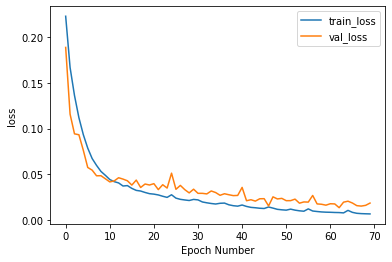

In [11]:

model_name_id = 'model_best_' + paramsTrain.model_type + '_' + \
    paramsTrain.seq_date + '_' + paramsTrain.dataset + '_' + \
    paramsTrain.model_name + '.h5'

if paramsTrain.train == True:
  trainTest.trainAndEvaluate(model_name_id)